In [48]:
import random as rn
import pickle
from datetime import datetime
import pandas as pd
from hs_gimme.db_facade.db_facade_factory import get_mongo_client_db
from hs_tree_blenders_creation.batch_runners.data_sets import get_account_test_set, get_account_train_set
from hs_gimme.application_status_history_classifier.machine_learning_status_classifier import \
    get_machine_learning_status_classifier
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
from datetime import timedelta
import copy
from collections import Counter
from sklearn.linear_model import LogisticRegression

In [2]:
ENV = 'production'
ACCOUNT = 'dallas'

In [3]:
mongo = gmcdb(ENV, ACCOUNT)

2024-03-05T15:34:20.229719Z [info     ] Mongos instances selected      environment=local file_path=/Users/dima/hiredscore/gimme/hs_gimme/db_facade/connection_string_builder.py function_name=get_selected_mongos_instances hostname=Dima-Shulga-MacBook-Pro hosts=['applicativedb-prod-mongos-5.omcomcom.com', 'applicativedb-prod-mongos-1.omcomcom.com'] line_number=38 module=hs_gimme.db_facade.connection_string_builder pid=11214


In [4]:
status_cls = get_machine_learning_status_classifier(ENV, ACCOUNT)

In [5]:
req_fields =  ['job_department',
              'country',
               'external_job_band',
               'external_recruiters',
               'top_category',
               'sub_category',
               'job_education',
               'seniority_level',
               'min_years_of_relevant_experience',
               'max_years_of_relevant_experience',
               'max_salary',
               'job_type',
               'is_visa_required',
               'is_remote_location', 
               'external_status',
               'industry',
               'open_date',
               'past_candidates_distribution_date',
               'is_recent_grad', 
               'is_intern',
               '_created_at',
               'date_posted',
               'job_create_date',
               'last_edit_date',
               'status_history',
               'recruiter_roles',
               'recruiting_type']

In [6]:
reference_date = datetime(2023, 11, 1)

In [7]:
reqs = list(mongo.req.find({'_created_at': {'$gt': reference_date}, 'date_posted': 
                            {'$gt': reference_date}, 'external_status': 'Filled'
                           }, req_fields))
len(reqs)

139

In [8]:
for r in reqs: 
    r['time_to_fill'] = (r['status_history']['Filled'][0] - r['status_history']['Post'][0]).days

In [9]:
req_ids = [r['_id'] for r in reqs]

In [10]:
app_fields = ['req_id', 'ats_application', 'is_internal', 'grade_data.explainable_score_data']

In [11]:
apps = list(mongo.application.find({'req_id': {'$in': req_ids}}, app_fields))
len(apps)

10050

In [12]:
for app in apps:
    app['phases_dates'] = status_cls.get_phases_reach_dates(app)
    app['max_status'] = status_cls.get_max_status(app)

In [13]:
req_to_apps = defaultdict(list)
for app in apps:
    if 'offer' in app['phases_dates'] and 'interview' not in app['phases_dates']:
        pass
    else:
        req_to_apps[app['req_id']].append(app)

In [14]:
def get_data_for_req(req):
    
    req_apps = req_to_apps[req['_id']]
    req_dates = {s: v[0] for s,v in req['status_history'].items()}
    if req_apps:
        req_dates['First apply'] =  min(a['ats_application']['date_applied'] for a in req_apps)
        for status in ['interview', 'offer']:
            req_dates['First ' + status] =  min(a['phases_dates'].get(status, datetime.now()) for a in req_apps)

        
        try:
            req_dates['First Interview Worthy Apply'] = min(a['ats_application']['date_applied'] for a in req_apps if a['max_status'] >= 2)
            req_dates['First Interview Worthy Interview'] = min(a['phases_dates']['interview'] for a in req_apps if a['max_status'] >= 2)

            req_dates['First Offer Worthy Apply'] = min(a['ats_application']['date_applied'] for a in req_apps if a['max_status'] >= 3)
            req_dates['First Offer Worthy Interview'] = min(a['phases_dates']['interview'] for a in req_apps if a['max_status'] >= 3)
        except:
            pass
    
    return req_dates

In [15]:
data = [get_data_for_req(r) for r in reqs]

In [16]:
df = pd.DataFrame(data)

In [17]:
df['Open to Post'] = (df['Post'] - df['Open']).dt.days
df['Post to Apply'] = (df['First apply'] - df['Post']).dt.days
df['Apply to Interview'] = (df['First interview'] - df['First apply']).dt.days
df['Interview to Offer'] = (df['First offer'] - df['First interview']).dt.days
df['Apply to Offer'] = (df['First offer'] - df['First apply']).dt.days
df['Post to Offer'] = (df['First offer'] - df['Post']).dt.days
df['Offer to Fill'] = (df['First offer'] - df['Open']).dt.days
df['Open to Fill'] = (df['Filled'] - df['Open']).dt.days
df['Post to Fill'] = (df['Filled'] - df['Post']).dt.days

df['Interview Worthy apply to Interview'] = (df['First Interview Worthy Interview'] - df['First Interview Worthy Apply']).dt.days
df['Offer Worthy apply to Interview'] = (df['First Offer Worthy Interview'] - df['First Offer Worthy Apply']).dt.days

In [18]:
df['Open to Post'].mean(), df['Post to Apply'].mean(), df['Apply to Interview'].mean(), df['Interview to Offer'].mean(), df['Offer to Fill'].mean()

(9.899280575539569,
 2.5579710144927534,
 7.840579710144928,
 10.884057971014492,
 32.1231884057971)

<Axes: >

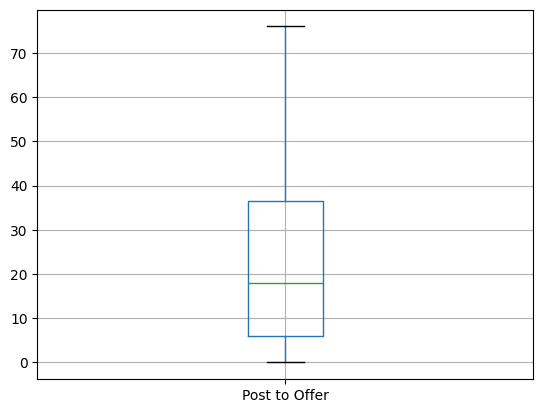

In [19]:
df.boxplot('Post to Offer')

In [20]:
df['Post to Apply'].mean(), df['Apply to Interview'].mean(), df['Interview to Offer'].mean()

(2.5579710144927534, 7.840579710144928, 10.884057971014492)

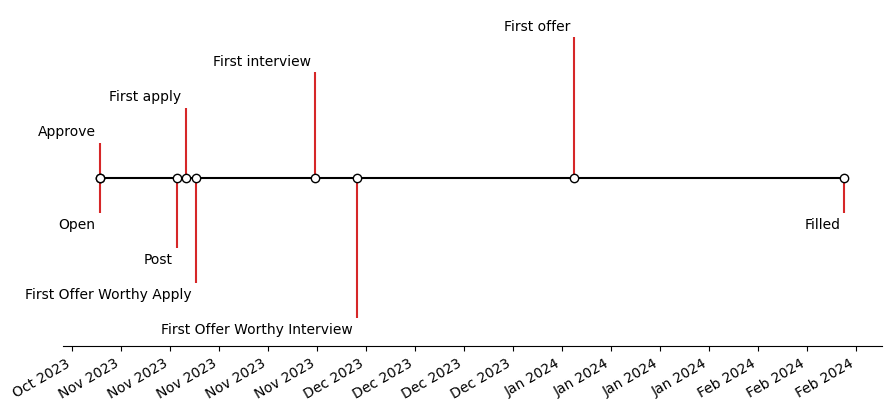

In [47]:
req = reqs[1]
req_apps = req_to_apps[req['_id']]
req_dates = {s: v[0] for s,v in req['status_history'].items()}
req_dates['First apply'] =  min(a['ats_application']['date_applied'] for a in req_apps)
for status in ['interview', 'offer']:
    req_dates['First ' + status] =  min(a['phases_dates'].get(status, datetime.now()) for a in req_apps)
    
    
# req_dates['First Interview Worthy Apply'] = min(a['ats_application']['date_applied'] for a in req_apps if a['max_status'] >= 2)
# req_dates['First Interview Worthy Interview'] = min(a['phases_dates']['interview'] for a in req_apps if a['max_status'] >= 2)

req_dates['First Offer Worthy Apply'] = min(a['ats_application']['date_applied'] for a in req_apps if a['max_status'] >= 3)
req_dates['First Offer Worthy Interview'] = min(a['phases_dates']['interview'] for a in req_apps if a['max_status'] >= 3)

names, dates  = list(zip(*sorted(req_dates.items(), key=lambda v: v[1])))

# Choose some nice levels
levels = np.tile([-1, 1, -2, 2, -3, 3, -4, 4],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), layout="constrained")

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

# format x-axis with 4-month intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [22]:
(req_dates['First Interview Worthy Interview'] - req_dates['First Interview Worthy Apply']).days

17

In [23]:
states = {
    'Waiting for Post', # --> Suggest to post
    'Waiting for Candidates', # --> Fetch Auto Reach
    'Waiting for Good Candidates', # --> Fetch Auto Reach, Screen
    'Waiting for interview conclude', # --> F1to HM
    'Waiting for promising interview conclude', # --> Suggest to Reject, Suggest Talking to HM
    'Has Offer', # --> Suggest to Reject
}

actions = {
    'Auto Fetch',
    'Suggest Moving to Interview', 
    'Suggest Reject', 
}

In [24]:
sb.pairplot(df[['Post to Offer', 'Open to Post', 'Post to Apply',  'Interview Worthy apply to Interview', 'Apply to Interview']])
plt.figure(figsize=(4,4))

<Figure size 400x400 with 0 Axes>

In [25]:
sb.regplot(data=df, y='Post to Offer', x='Interview Worthy apply to Interview')

<Axes: xlabel='Interview Worthy apply to Interview', ylabel='Post to Offer'>

In [26]:
sb.regplot(data=df, x='Post to Apply', y='Post to Offer')

<Axes: xlabel='Post to Apply', ylabel='Post to Offer'>

In [27]:
sb.regplot(data=df, x='Post to Offer', y='Open to Post')

<Axes: xlabel='Post to Offer', ylabel='Open to Post'>

In [28]:
len(req_apps)

136

In [29]:
req['status_history']

{'Open': [datetime.datetime(2023, 10, 30, 0, 0)],
 'Approve': [datetime.datetime(2023, 10, 30, 0, 0)],
 'Post': [datetime.datetime(2023, 11, 10, 0, 0),
  datetime.datetime(2024, 1, 5, 0, 0)],
 'Filled': [datetime.datetime(2024, 2, 13, 8, 8, 43, 619000)]}

In [30]:
app['phases_dates']

{'review_candidate': datetime.datetime(2024, 2, 8, 16, 10, 23, 732000),
 'rejected': datetime.datetime(2024, 2, 12, 20, 55, 20, 722000)}

In [31]:
def get_app_waiting_time(app):
    try:
        first_response = min(d for k, d in app['phases_dates'].items() if k in {'rejected', 'interview'})
        return (first_response - app['ats_application']['date_applied']).days
    except:
        return 0

In [32]:
def simulate_best(req_apps):
    new_apps = copy.deepcopy(req_apps)
    
    offer_days = None
    
    for app in new_apps:
        if 'offer' in app['phases_dates'] and 'interview' in app['phases_dates']:
            offer_days = (app['phases_dates']['offer'] - app['phases_dates']['interview']).days
        elif 'offer' in app['phases_dates'] and 'interview' not in app['phases_dates']:
            offer_days = (app['phases_dates']['offer'] - app['ats_application']['date_applied']).days
            
        if 'interview' not in app['phases_dates'] and 'offer' not in app['phases_dates']:
            app['phases_dates']['rejected'] = app['ats_application']['date_applied'] + timedelta(days=1)
        elif 'offer' not in app['phases_dates']:
            app['phases_dates']['interview'] = app['ats_application']['date_applied'] + timedelta(days=1)
            app['phases_dates']['rejected'] = app['ats_application']['date_applied'] + timedelta(days=2)
        else:
            app['phases_dates']['interview'] = app['ats_application']['date_applied'] + timedelta(days=1)
            app['phases_dates']['offer'] = app['ats_application']['date_applied'] + timedelta(days=offer_days)

    return new_apps

In [33]:
def simulate_req(req, simulated_req_apps, print_pipes=False):
    req_state = 'posted'
    date = req['status_history']['Post'][0]
    offer_date = None
    days = Counter()
    while True:
        day_actions = 0
        is_working_day = False
        if print_pipes:
            print(date.date(), end=' ')
        for app in simulated_req_apps:
            if app['ats_application']['date_applied'].date() == date.date():
                if print_pipes:
                    print('\033[1m\033[33mA\033[0m', end=' ')
            elif app['phases_dates'].get('rejected', datetime.now()).date() == date.date():
                if print_pipes:
                    print('\033[1m\033[31mR\033[0m', end=' ')
                day_actions += 1
            elif app['phases_dates'].get('interview', datetime.now()).date() == date.date():
                if print_pipes:
                    print('\033[1m\033[34mV\033[0m', end=' ')
                day_actions += 1
            elif app['phases_dates'].get('offer', datetime.now()).date() == date.date():
                offer_date = date.date() 
                day_actions += 1
                if print_pipes:
                    print('\033[1m\033[32mO\033[0m', end=' ')
            else:
                if print_pipes:
                    print('|', end=' ')
                    
        if print_pipes:
            print()
        
        date = date + timedelta(days=1)
        days[date] = day_actions
        if date.date() == req['status_history']['Filled'][0].date():
            break
    
    return {
        'post_to_offer': ((offer_date or req['status_history']['Filled'][0].date()) - req['status_history']['Post'][0].date()).days,
        'waiting_days': [get_app_waiting_time(a) for a in simulated_req_apps],
        'days_actions': days,
    }


In [34]:
simulated_req_apps = simulate_best(req_apps)

In [35]:
user_to_reqs = defaultdict(list)
for req in reqs:
    user_to_reqs[req['recruiter_roles']['recruiter']].append(req)

In [36]:
data = []
for user, user_reqs in user_to_reqs.items():
    
    orig_vals = []
    best_vals = []
    
    orig_waiting_days = []
    orig_days_to_actions = Counter()
    best_waiting_days = []
    best_days_to_actions = Counter()
    
    for req in user_reqs: 
        req_apps = req_to_apps[req['_id']]
        orig_req_vals = simulate_req(req, req_apps)
        
        orig_days_to_actions += orig_req_vals['days_actions']
        orig_waiting_days += orig_req_vals['waiting_days']
        
        simulated_req_apps = simulate_best(req_apps)
        best_req_vals = simulate_req(req, simulated_req_apps)
        
        best_days_to_actions += best_req_vals['days_actions']
        best_waiting_days += best_req_vals['waiting_days']
        
        orig_vals.append(orig_req_vals)
        best_vals.append(best_req_vals)
        
        orig_post_to_offer = [v['post_to_offer'] for v in orig_vals]
        best_post_to_offer = [v['post_to_offer'] for v in best_vals]
        
    d = {
        'user_id': user,
        'num_of_reqs': len(user_reqs),
        'original_post_to_ofer_mean': np.mean(orig_post_to_offer),
        'best_post_to_ofer_mean': np.mean(best_post_to_offer),
        
        'original_post_to_ofer_max': np.max(orig_post_to_offer),
        'best_post_to_ofer_max': np.max(best_post_to_offer),
        
        'orig_num_of_actions_per_day_mean': np.mean(list(orig_days_to_actions.values())),
        'best_num_of_actions_per_day_mean': np.mean(list(best_days_to_actions.values())),
        
        'orig_waiting_days_mean': np.mean(orig_waiting_days),
        'best_waiting_days_mean': np.mean(best_waiting_days),
    }
    
    
    data.append(d)

/Users/dima/.virtualenvs/hs/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dima/.virtualenvs/hs/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [37]:
pd.DataFrame(data)

,user_id,num_of_reqs,original_post_to_ofer_mean,best_post_to_ofer_mean,original_post_to_ofer_max,best_post_to_ofer_max,orig_num_of_actions_per_day_mean,best_num_of_actions_per_day_mean,orig_waiting_days_mean,best_waiting_days_mean
0,7d81a8f2a92101facddd09d6630ea6a2,2,39.000000,27.0,45,41,31.333333,13.428571,18.787546,1.0
1,16e250631a9e011b63050bd1c2076491,3,21.666667,19.0,56,33,10.600000,11.357143,18.647059,1.0
2,9904c4e6250001b49bc855cff822a476,1,2.000000,11.0,2,11,1.000000,1.000000,0.000000,1.0
3,01a11fe05ac9011f5c5f437e859b0000,1,72.000000,70.0,72,70,2.444444,2.384615,3.192308,1.0
4,74f2ae1895fc015196c72d61253bbdd5,1,40.000000,40.0,40,40,1.000000,2.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
63,87c0a5f392d0017968b3f28b002315d6,1,6.000000,32.0,6,32,1.000000,1.000000,3.000000,1.0
64,29c292443a1d01e8cd391c31df572c75,1,21.000000,21.0,21,21,NaN,1.000000,0.000000,1.0
65,7f702b58bf0501200c80add101ff0000,1,7.000000,40.0,7,40,1.000000,1.000000,4.000000,1.0
66,2fd0bae6e647013856eddd210a108610,1,6.000000,26.0,6,26,3.166667,4.200000,3.823529,1.0


In [38]:
simulate_req(req, req_apps, print_pipes=True)

2024-01-30 | 
2024-01-31 | 
2024-02-01 | 
2024-02-02 | 
2024-02-03 | 
2024-02-04 | 
2024-02-05 A 
2024-02-06 | 
2024-02-07 V 
2024-02-08 O 
2024-02-09 | 
2024-02-10 | 
2024-02-11 | 
2024-02-12 | 
2024-02-13 | 
2024-02-14 | 
2024-02-15 | 
2024-02-16 | 
2024-02-17 | 
2024-02-18 | 
2024-02-19 | 
2024-02-20 | 
2024-02-21 | 
2024-02-22 | 
2024-02-23 | 
2024-02-24 | 
2024-02-25 | 
2024-02-26 | 
2024-02-27 | 
2024-02-28 | 
2024-02-29 | 
2024-03-01 | 
2024-03-02 | 
2024-03-03 | 


{'post_to_offer': 9,
 'waiting_days': [1],
 'days_actions': Counter({datetime.datetime(2024, 2, 8, 0, 0): 1,
          datetime.datetime(2024, 2, 9, 0, 0): 1,
          datetime.datetime(2024, 1, 31, 0, 0): 0,
          datetime.datetime(2024, 2, 1, 0, 0): 0,
          datetime.datetime(2024, 2, 2, 0, 0): 0,
          datetime.datetime(2024, 2, 3, 0, 0): 0,
          datetime.datetime(2024, 2, 4, 0, 0): 0,
          datetime.datetime(2024, 2, 5, 0, 0): 0,
          datetime.datetime(2024, 2, 6, 0, 0): 0,
          datetime.datetime(2024, 2, 7, 0, 0): 0,
          datetime.datetime(2024, 2, 10, 0, 0): 0,
          datetime.datetime(2024, 2, 11, 0, 0): 0,
          datetime.datetime(2024, 2, 12, 0, 0): 0,
          datetime.datetime(2024, 2, 13, 0, 0): 0,
          datetime.datetime(2024, 2, 14, 0, 0): 0,
          datetime.datetime(2024, 2, 15, 0, 0): 0,
          datetime.datetime(2024, 2, 16, 0, 0): 0,
          datetime.datetime(2024, 2, 17, 0, 0): 0,
          datetime.datetime(2024

In [39]:
len(req_apps)

1

In [40]:
req = reqs[0]

In [41]:
req_apps = req_to_apps[req['_id']]

In [42]:
x = simulate_req(req, req_apps, print_pipes=True)
x['post_to_offer'], np.mean(x['waiting_days'])

2023-11-27 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-28 A A A A A | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-29 | | | | | A A A A A A A A A A A | | | | | | | | | | | | | | | | | | | | 
2023-11-30 | | | | | | | | | | | | | | | | A A A | | | | | | | | | | | | | | | | | 
2023-12-01 | | | | | | | | | | | | | | | | | | | A | | | | | | | | | | | | | | | | 
2023-12-02 | | | | | | | | | | | | | | | | | | | | A A | | | | | | | | | | | | | | 
2023-12-03 | | | | | | | | | | | | | | | | | | | | | | A A A A A | | | | | | | | | 
2023-12-04 | | | | | | | | | | | | | | | | | | | | | | | | | | | A A | | | | | | | 
2023-12-05 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | A A A A | | | 
2023-12-06 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | A A A 
2023-12-07 | | | | | V | | | | | | | | | | | | | | | | | | | | V | | | | | | | V | 
2023-12-08 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |

(45, 15.833333333333334)

In [43]:
best_reqs = simulate_best(req_apps)

In [44]:
x = simulate_req(req, best_reqs, print_pipes=True)
x['post_to_offer'], np.mean(x['waiting_days'])

2023-11-27 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-28 A A A A A | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-29 R R R R R A A A A A A A A A A A | | | | | | | | | | | | | | | | | | | | 
2023-11-30 | | | | | V R R R R R R R R R R A A A | | | | | | | | | | | | | | | | | 
2023-12-01 | | | | | R | | | | | | | | | | R R R A | | | | | | | | | | | | | | | | 
2023-12-02 | | | | | | | | | | | | | | | | | | | R A A | | | | | | | | | | | | | | 
2023-12-03 | | | | | | | | | | | | | | | | | | | | R R A A A A A | | | | | | | | | 
2023-12-04 | | | | | | | | | | | | | | | | | | | | | | R R R R V A A | | | | | | | 
2023-12-05 | | | | | | | | | | | | | | | | | | | | | | | | | | | R R A A A A | | | 
2023-12-06 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | R R R R A A A 
2023-12-07 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | R V R 
2023-12-08 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |

(41, 1.0)

In [45]:
def get_req_features(req, req_apps):
    

IndentationError: expected an indented block (3387006614.py, line 2)